In [0]:
import torch
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image 

# Initial data
w_size = 565
h_size = 584
resize = 256
pad = h_size-w_size

# Dataset transform
transform_down = transforms.Compose(
    [
     transforms.Pad((int(pad/2), 0, int(pad/2)+1, 0)),
     transforms.Resize(resize),
     transforms.ToTensor(),
    ])

transform_up = transforms.Compose(
    [
     transforms.ToPILImage(),
     transforms.Resize(h_size, interpolation=2),
     transforms.CenterCrop((h_size, w_size)),
     transforms.ToTensor(),
     transforms.Lambda(lambda tensor:torch.round(tensor)),
     transforms.ToPILImage(),
    ])

**Custom Dataset**

In [0]:
class RetinaDataset(Dataset):
    def __init__(self, img, lab, path1, path2, channel=None, transform=None):
        self.img = img
        self.lab = lab
        self.path1 = path1
        self.path2 = path2
        self.channel = channel
        self.transform = transform

    def __len__(self):
        path, dirs, files = next(os.walk(self.path1))
        return len(files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.path1, str(idx+1)+self.img)
        image = Image.open(self.path1+str(idx+1)+self.img)
        label = Image.open(self.path2+str(idx+1)+self.lab)

        if self.transform:
            x, y = (self.transform(image), self.transform(label))
        if self.channel is not None:
            x = x[self.channel]

        return x, y

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

path_train = 'drive/My Drive/Colab Notebooks/03_retina/train/'
path_label = 'drive/My Drive/Colab Notebooks/03_retina/label/'
path_test = 'drive/My Drive/Colab Notebooks/03_retina/test/'

trainset = RetinaDataset(img='_training.tif', lab='_manual1.gif', 
                         path1=path_train, path2=path_label, channel=1, transform=transform_down)
testset = RetinaDataset(img='_test.tif', lab='_manual1.gif', 
                        path1=path_test, path2=path_label, channel=1, transform=transform_down)

trainloader = DataLoader(trainset, batch_size=5, num_workers=1)
testloader = DataLoader(testset, batch_size=5, num_workers=1)

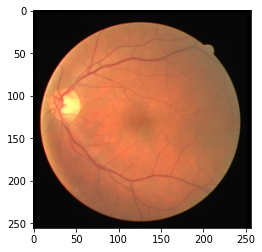

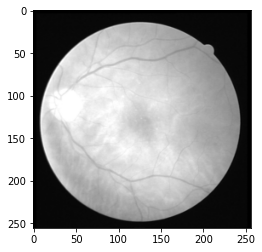

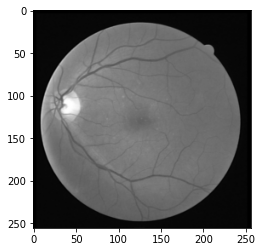

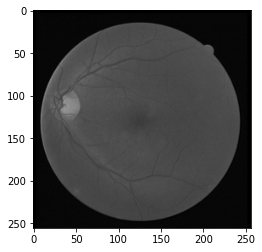

In [0]:
# print RGB channels
printset = RetinaDataset(img='_training.tif', lab='_manual1.gif', 
                         path1=path_train, path2=path_label, transform=transform_down)

imshow(torchvision.utils.make_grid([printset[0][0]]))
imshow(torchvision.utils.make_grid([printset[0][0][0]]))
imshow(torchvision.utils.make_grid([printset[0][0][1]]))
imshow(torchvision.utils.make_grid([printset[0][0][2]]))

**Initializing Network**

In [0]:
# full assembly of the sub-parts to form the complete net
import torch
import torch.nn as nn
import torch.optim as optim

class Double_conv(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(Double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(num_features=out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(num_features=out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class Conv_down(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(Conv_down, self).__init__()
        self.conv = Double_conv(in_ch, out_ch)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        pool_x = self.pool(x)
        return pool_x, x

class Conv_up(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(Conv_up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = Double_conv(in_ch, out_ch)
  
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1 = torch.cat((x1, x2), dim=1)
        x1 = self.conv(x1)
        return x1

class UNet(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.Conv_down1 = Conv_down(in_channels, 64)
        self.Conv_down2 = Conv_down(64, 128)
        self.Conv_down3 = Conv_down(128, 256)
        self.Conv_down4 = Conv_down(256, 512)
        self.Conv_down5 = Conv_down(512, 1024)
        self.Conv_up1 = Conv_up(1024, 512)
        self.Conv_up2 = Conv_up(512, 256)
        self.Conv_up3 = Conv_up(256, 128)
        self.Conv_up4 = Conv_up(128, 64)
        self.Conv_out = nn.Conv2d(64, out_channels, 1, padding=0, stride=1)

    def forward(self, x):
        #print("x.shape = ", x.shape)
        x, conv1 = self.Conv_down1(x)
        #print("dConv1 => down1|", x.shape)
        x, conv2 = self.Conv_down2(x)
        #print("dConv2 => down2|", x.shape)
        x, conv3 = self.Conv_down3(x)
        #print("dConv3 => down3|", x.shape)
        x, conv4 = self.Conv_down4(x)
        #print("dConv4 => down4|", x.shape)
        _, x = self.Conv_down5(x)
        #print("dConv5|", x.shape)
        x = self.Conv_up1(x, conv4)
        #print("up1 => uConv1|", x.shape)
        x = self.Conv_up2(x, conv3)
        #print("up2 => uConv2|", x.shape)
        x = self.Conv_up3(x, conv2)
        #print("up3 => uConv3|", x.shape)
        x = self.Conv_up4(x, conv1)
        #print("up3 => uConv4|", x.shape)
        x = self.Conv_out(x)
        #x = self.Conv_final(x)

        return torch.sigmoid(x)

unet = UNet(1, 1)
'''
# load model
path = "drive/My Drive/Colab Notebooks/03_retina/models"
model_name = "retina1_70.pt"
unet = UNet(1, 1)
unet.load_state_dict(torch.load(f"{path}/{model_name}"))
'''
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=0.001)
#optimizer = optim.SGD(unet.parameters(), lr=0.005, momentum=0.9)

loss_list = []

**Training Network**

In [0]:
path_output = 'drive/My Drive/Colab Notebooks/03_retina/output/'
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.unsqueeze(1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)

        for j in range(len(outputs)):
            test = outputs[j]
            test = transform_up(test)
            test.save(f"{path_output}/DSC_{i*5+j}.gif","gif")

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % len(trainloader) == len(trainloader)-1: 
            print(f"[{epoch+1}, {i+1}], loss: {running_loss/len(trainloader):.3f}")
            loss_list.append(loss.item())
            running_loss = 0.0

print('Finished Training')

[1, 3], loss: 0.690
[2, 3], loss: 0.689
[3, 3], loss: 0.689
[4, 3], loss: 0.689
[5, 3], loss: 0.689
[6, 3], loss: 0.689
[7, 3], loss: 0.688
[8, 3], loss: 0.688
[9, 3], loss: 0.688
[10, 3], loss: 0.688
[11, 3], loss: 0.688
[12, 3], loss: 0.687
[13, 3], loss: 0.687
[14, 3], loss: 0.687
[15, 3], loss: 0.687
[16, 3], loss: 0.687
[17, 3], loss: 0.687
[18, 3], loss: 0.686
[19, 3], loss: 0.686
[20, 3], loss: 0.686
[21, 3], loss: 0.686
[22, 3], loss: 0.686
[23, 3], loss: 0.686
[24, 3], loss: 0.686
[25, 3], loss: 0.686
[26, 3], loss: 0.686
[27, 3], loss: 0.686
[28, 3], loss: 0.685
[29, 3], loss: 0.685
[30, 3], loss: 0.685
[31, 3], loss: 0.685
[32, 3], loss: 0.685
[33, 3], loss: 0.685
[34, 3], loss: 0.685
[35, 3], loss: 0.684
[36, 3], loss: 0.684
[37, 3], loss: 0.684
[38, 3], loss: 0.684
[39, 3], loss: 0.684
[40, 3], loss: 0.684
[41, 3], loss: 0.684
[42, 3], loss: 0.684
[43, 3], loss: 0.684
[44, 3], loss: 0.684
[45, 3], loss: 0.684
[46, 3], loss: 0.684
[47, 3], loss: 0.684
[48, 3], loss: 0.684
[

Text(0, 0.5, 'Loss')

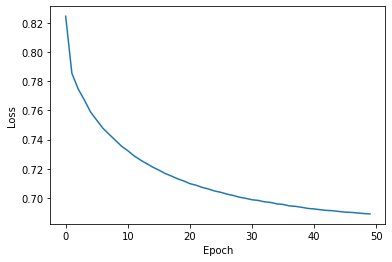

In [0]:
# plot loss
# --------------
plt.plot(range(len(loss_list)), np.array(loss_list))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [0]:
# testing set
# --------------
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.unsqueeze(1)
outputs = unet(images)

"\ntest = outputs[0].detach().numpy()\ntest = test.squeeze(0)\nprint(test.shape)\nplt.imshow(test, cmap='gray')\n"

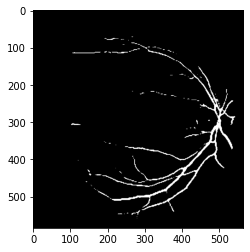

In [0]:
# save output images
# -------------------
path_output = 'drive/My Drive/Colab Notebooks/03_retina/output/'
for i in range(len(outputs)):
    test = outputs[i]
    test = transform_up(test)
    
    # save outputs
    test.save(f"{path_output}/{i+1}_test.png","png")
    plt.imshow(test, cmap='gray')

'''
test = outputs[0].detach().numpy()
test = test.squeeze(0)
print(test.shape)
plt.imshow(test, cmap='gray')
'''

In [0]:
# save model
# -----------

path = "drive/My Drive/Colab Notebooks/03_retina/models"
model_name = "retina1_50_SGD.pt"
model_loss = "retina1_50_SGD.csv"
torch.save(unet.state_dict(), f"{path}/{model_name}")

# save loss
import pandas as pd
df = pd.DataFrame(loss_list)
df.to_csv(f"{path}/{model_loss}")

# read loss
df = pd.read_csv(f"{path}/{model_loss}")
tmp = df['0'].tolist()